<a href="https://colab.research.google.com/github/youssef1232004/Deep-learning-project-/blob/main/vgg16_model_for_Car_vs_Bike_Classification_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
 95% 98.0M/103M [00:02<00:00, 50.1MB/s]
100% 103M/103M [00:02<00:00, 48.3MB/s] 


In [ ]:
import os
from os import listdir
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import zipfile

# Define the paths for the zip file and extraction directory
zip_file_path = "/content/car-vs-bike-classification-dataset.zip"  # Path to the dataset zip file
extract_path = "/content"  # Path to extract the contents

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, mode='r') as zip_ref:
    zip_ref.extractall(path=extract_path)  # Extract to the target directory


In [ ]:

# Define the main directory containing the dataset
main_directory = "/content/Car-Bike-Dataset"

# Initialize lists for file paths and labels
file_paths = []
file_labels = []

# Traverse through each folder and collect file paths and labels
for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    for file_name in os.listdir(folder_path):
        file_paths.append(os.path.join(folder_path, file_name))
        file_labels.append(folder_name)

# Create a DataFrame to store the file paths and their corresponding labels
dataset_df = pd.DataFrame({"File Path": file_paths, "Labels": file_labels})



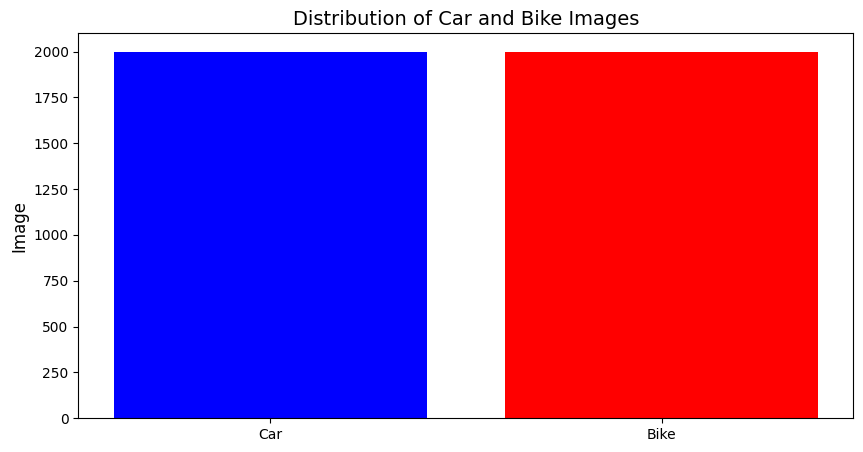

In [ ]:
# Calculate the count of each label in the DataFrame
label_counts = dataset_df["Labels"].value_counts()

# Plot the distribution of labels
plt.figure(figsize=(10,5))
plt.bar(label_counts.index, label_counts.values, color=["blue", "red"])
plt.title("Distribution of Car and Bike Images", fontsize=14)
plt.ylabel("Image", fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [ ]:


X_train, X_test = train_test_split(dataset_df, test_size=0.2, shuffle=True, random_state=42)

# Print the shapes of the resulting datasets
print('The shape of train data', X_train.shape)
print('The shape of test data', X_test.shape)


The shape of train data (3200, 2)
The shape of test data (800, 2)


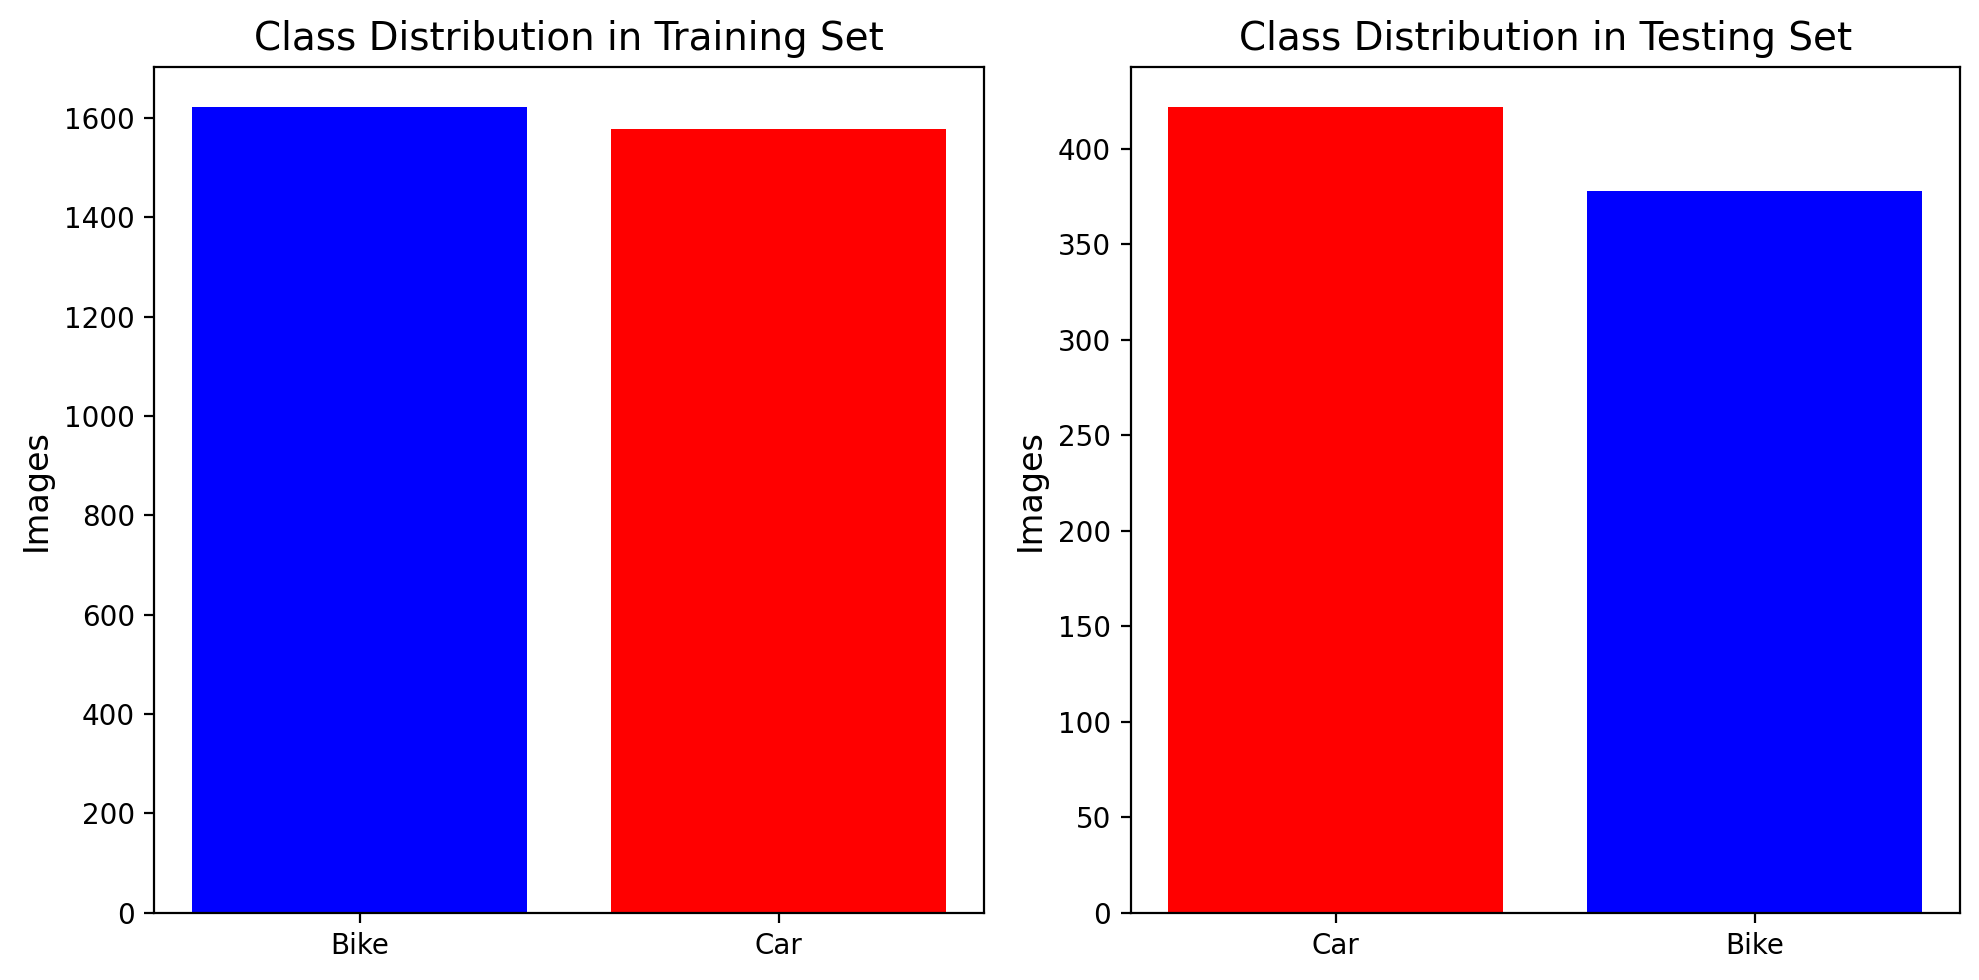

In [ ]:
# Calculate the count of each label in the training and testing sets
train_label_counts = X_train["Labels"].value_counts()
test_label_counts = X_test["Labels"].value_counts()

# Plot the class distribution for training and testing sets
plt.figure(figsize=(10, 5), dpi=200)

# Training set distribution
plt.subplot(1, 2, 1)  # Subplot 1: Training set
plt.bar(train_label_counts.index, train_label_counts.values, color=["blue", "red"])
plt.title("Class Distribution in Training Set", fontsize=14)
plt.ylabel("Images", fontsize=12)

# Testing set distribution
plt.subplot(1, 2, 2)  # Subplot 2: Testing set
plt.bar(test_label_counts.index, test_label_counts.values,  color=["red", "blue"])
plt.title("Class Distribution in Testing Set", fontsize=14)
plt.ylabel("Images", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
# Define ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize image pixels to the range 0-1
    validation_split=0.3
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)


In [ ]:
# Define image processing parameters
image_size = (224, 224)
image_channel = 3
batch_size = 16


In [ ]:
# Create training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/content/Car-Bike-Dataset",
    x_col="File Path",
    y_col="Labels",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    subset="training",
    target_size=image_size
)

# Create validation data generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/content/Car-Bike-Dataset",
    x_col="File Path",
    y_col="Labels",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    subset="validation",
    target_size=image_size
)

# Create testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory="/content/Car-Bike-Dataset",
    x_col="File Path",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=False,
    target_size=image_size,
    class_mode="binary"
)

Found 2240 validated image filenames belonging to 2 classes.
Found 960 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


# Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

# Add custom classification layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = Dropout(0.5)(x)  # Increase dropout rate
x = Dense(1, activation='sigmoid')(x)# Final output layer with sigmoid for binary classification

# Define the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with binary_crossentropy loss for binary classification
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.8745 - loss: 3.0835 - val_accuracy: 0.9500 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9521 - loss: 0.3145 - val_accuracy: 0.9698 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9538 - loss: 0.2558 - val_accuracy: 0.9583 - val_loss: 0.2266 - learning_rate: 0.0010
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.9502 - loss: 0.2458 - val_accuracy: 0.9667 - val_loss: 0.2030 - learning_rate: 0.0010
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.9560 - loss: 0.2371 - val_accuracy: 0.9708 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9483 - loss: 0.2361 - val_accuracy: 0.9771 - val_loss: 0.1765 - learning_rate: 0.0010
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.9

In [ ]:
# Retrieve final training accuracy and loss
train_acc = history.history['accuracy'][-1] * 100
train_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Training Loss: {train_loss:.4f}")

# Retrieve final validation accuracy and loss
val_acc = history.history['val_accuracy'][-1] * 100
val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {val_acc:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

# Evaluate the model on the testing set using the test_generator
test_loss, test_acc = model.evaluate(test_generator)  # Use test_generator instead of test_images
print(f"Testing Accuracy: {test_acc * 100:.2f}%")
print(f"Testing Loss: {test_loss:.4f}")


Final Training Accuracy: 95.49%
Final Training Loss: 0.2069
Final Validation Accuracy: 96.88%
Final Validation Loss: 0.1775
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9711 - loss: 0.1786
Testing Accuracy: 97.50%
Testing Loss: 0.1689


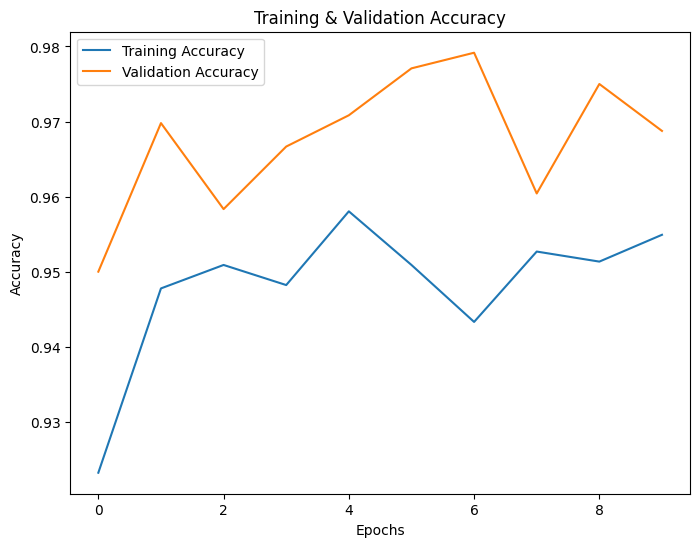

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the number of epochs (length of the training history data)
epochs = range(len(accuracy))

# Create a single plot (just for accuracy)
fig, ax = plt.subplots(figsize=(8, 6))

# Plot training and validation accuracy
ax.plot(epochs, accuracy, label='Training Accuracy')
ax.plot(epochs, val_accuracy, label='Validation Accuracy')
ax.set_title('Training & Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

# Show the plot
plt.show()


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step


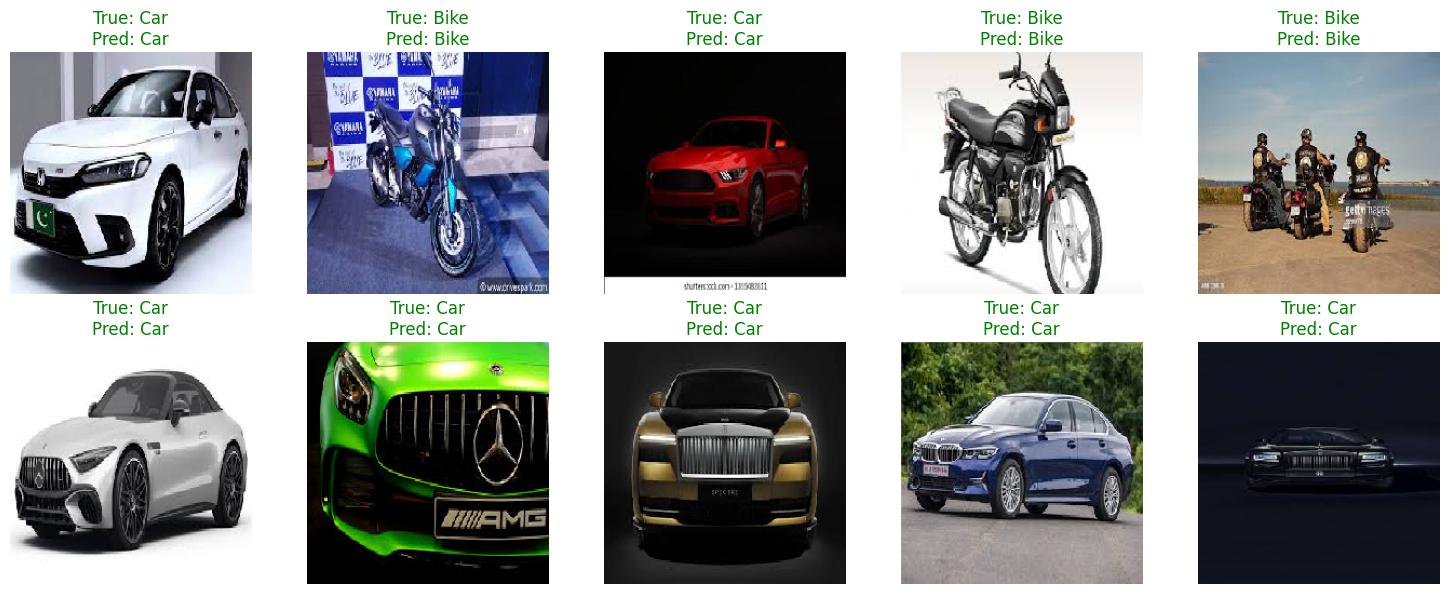

In [ ]:
# Assuming you have 'test_generator' defined from a previous cell
pred = model.predict(test_generator)
pred_labels = (pred > 0.5).astype(int)

# Define the labels dictionary - Make sure this matches your class assignments
labels = {0: 'Bike', 1: 'Car'}

# Map predictions to class names
pred_classes = [labels[label[0]] for label in pred_labels]

# Get a batch of images and labels from the test generator
images, true_labels_batch = next(test_generator)  # Get a batch of data

# Select a subset of images to display (e.g., the first 10)
num_images_to_display = 10
images_to_display = images[:num_images_to_display]
true_labels_to_display = true_labels_batch[:num_images_to_display]  # True labels for displayed images
pred_labels_to_display = pred_labels[:num_images_to_display]  # Predicted labels for displayed images
pred_classes_to_display = pred_classes[:num_images_to_display] # Predicted classes for displayed images


# Create a figure and subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns for 10 images
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate through the images and plot them with predictions
for i, ax in enumerate(axes):
    ax.imshow(images_to_display[i])
    ax.axis('off')  # Hide axes

    # Get the true and predicted labels for the current image
    true_label = true_labels_to_display[i]  # Get true numerical label
    pred_label = pred_labels_to_display[i][0] # Get predicted numerical label

    #Map to class name
    true_class = labels[true_label]
    pred_class = labels[pred_label]
    # Set the title with true and predicted labels
    ax.set_title(f"True: {true_class}\nPred: {pred_class}", color='green' if true_label == pred_label else 'red')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
y_test = list(X_test['Labels']) # Changed 'label' to 'Labels'
report = classification_report(y_test, pred_classes, output_dict=True) # pred_classes maps prediction to class names
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Bike,0.971053,0.976190,0.973615,378.000
Car,0.978571,0.973934,0.976247,422.000
accuracy,0.975000,0.975000,0.975000,0.975
macro avg,0.974812,0.975062,0.974931,800.000
weighted avg,0.975019,0.975000,0.975003,800.000


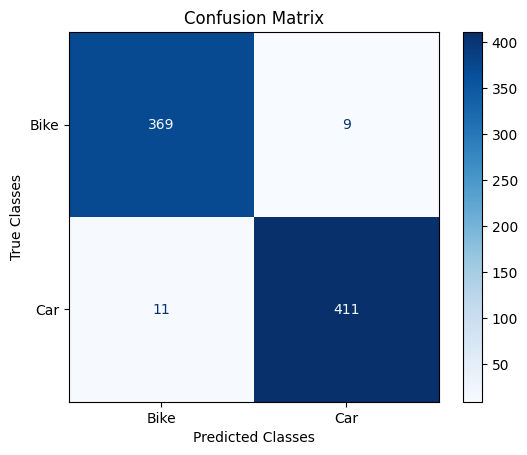

In [ ]:


# Get the true labels from the test generator (assuming you have 'test_generator')
y_test = test_generator.classes

# Map the true labels to class names (Bike or Car)
y_test_labels = [labels[label] for label in y_test] # 'labels' dict is defined in a previous cell

# Convert true labels to numerical labels (0 for 'Bike', 1 for 'Car')
y_test_numeric = [0 if label == 'Bike' else 1 for label in y_test_labels]

# Convert prediction probabilities to binary predictions (0 or 1) using a threshold
pred_binary = (pred > 0.5).astype(int)

# Now, create the confusion matrix
cm = confusion_matrix(y_test_numeric, pred_binary)

# Define your class names (matching the numerical labels)
class_names = ['Bike', 'Car']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Change the color to blue
disp.plot(cmap='Blues')

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')

plt.show()